In [67]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import visualkeras
from PIL import ImageFont
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_curve

In [68]:
 # (liczba próbek, liczba kanałów, liczba odczytów na kanał), a etykiety są binarne.
X = pd.read_csv(r"C:\MasterThesis\v1.0\sEEG_dataset.csv")
X = X.dropna()
print(X.shape)
y = X['labels']
X = X.drop('labels', axis=1)
print(X.isnull().values.any())
X.shape

(180, 4501)
False


(180, 4500)

### Class balancing

In [69]:
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(X, y)

In [70]:
X = X
y = y.values

# Reshape danych do formatu [próbki, kanały, odczyty]
# Zakładając, że masz 2 kanały i 225 odczytów na kanał
# X = X.reshape(-1, 2, 225)
print(f"x shape = {X.shape}, y shape = {y.shape}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

x shape = (210, 4500), y shape = (210,)
(168, 4500)


In [71]:
input_shape = (4500, 1)

# Tworzenie modelu
model = Sequential()
# Dodanie warstwy LSTM
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))

# Dodanie warstwy Dropout do zapobiegania przeuczeniu
model.add(Dropout(0.5))

# Dodanie drugiej warstwy LSTM
model.add(LSTM(32, return_sequences=False))

# Kolejna warstwa Dropout
model.add(Dropout(0.5))

# Dodanie warstwy Dense na końcu do przewidywania wyników
model.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              # metrics=['accuracy', keras.losses.mean_squared_error, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
              metrics='accuracy')

# Wyświetlenie struktury modelu
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4500, 64)          16896     
                                                                 
 dropout_12 (Dropout)        (None, 4500, 64)          0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [72]:
# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='LSTM_pupilometry_model.png', min_xy=10, min_z=10, scale_xy=100, scale_z=100, one_dim_orientation='x')

In [73]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
model_file = r"C:\Users\DAMS\PycharmProjects\MasterThesis\LSTM_pupilometry_model"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file,
                    monitor="val_accuracy", mode="max",
                    save_best_only=True, verbose=1, save_weights_only=True)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint])

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.5238
Epoch 1: val_accuracy improved from -inf to 0.45238, saving model to C:\Users\DAMS\PycharmProjects\MasterThesis\LSTM_pupilometry_model
6/6 [==============================] - 31s 5s/step - loss: 0.7032 - accuracy: 0.5238 - val_loss: 0.7243 - val_accuracy: 0.4524
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.5417
Epoch 2: val_accuracy did not improve from 0.45238
6/6 [==============================] - 28s 5s/step - loss: 0.6761 - accuracy: 0.5417 - val_loss: 0.7157 - val_accuracy: 0.4524
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5655
Epoch 3: val_accuracy did not improve from 0.45238
6/6 [==============================] - 28s 5s/step - loss: 0.6902 - accuracy: 0.5655 - val_loss: 0.7003 - val_accuracy: 0.4286
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5417
Epoch 4: val_a

In [74]:
model.load_weights(model_file)

In [75]:
metrics = model.evaluate(X_val, y_val)
print(metrics)

2/2 [==============================] - 1s 588ms/step - loss: 0.7243 - accuracy: 0.4524
[0.7242856621742249, 0.4523809552192688]


In [76]:
predict_x=model.predict(X_val)
y_pred=np.argmax(predict_x,axis=1)

2/2 [==============================] - 2s 579ms/step


In [77]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

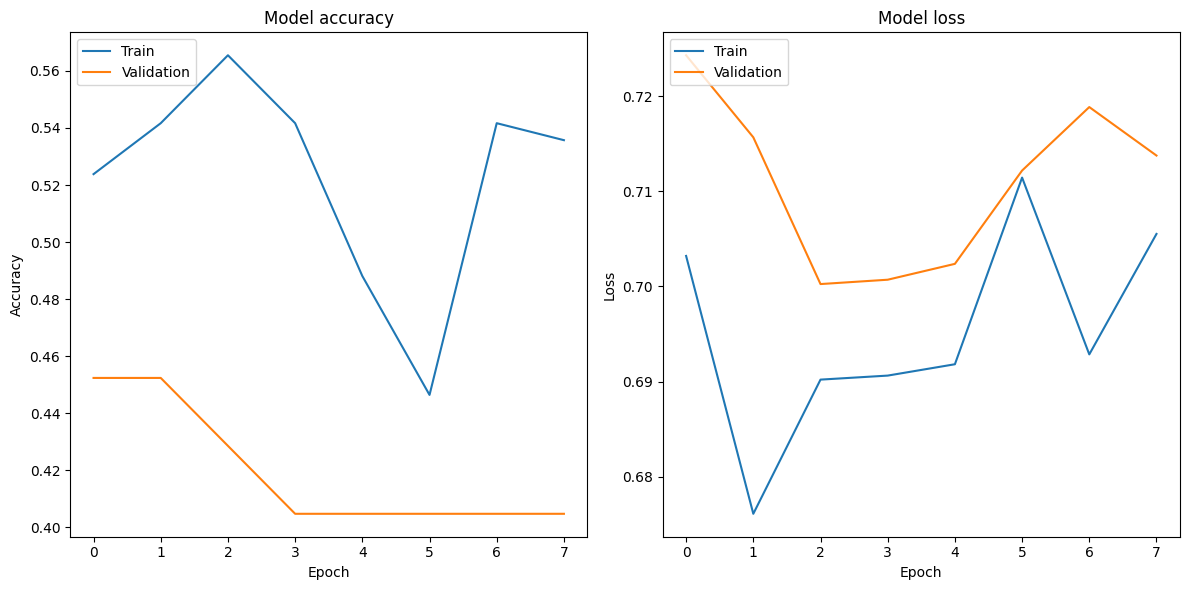

In [78]:
# Plot training & validation accuracy values
f = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'CONFUSION MATRIX')

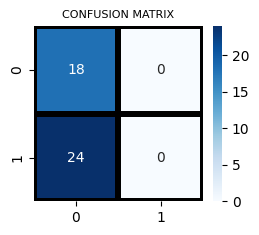

In [79]:
#Confusion matrix
plt.figure(figsize=(6,5))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,cmap="Blues",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=8)

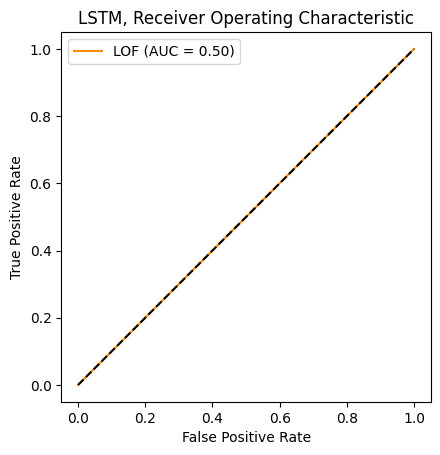

In [80]:
### plot ROC curve
# model.fit(X)
# y_pred = model.negative_outlier_factor_
#

RocCurveDisplay.from_predictions(
    y_val, y_pred,
    name="LOF",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM, Receiver Operating Characteristic")
plt.legend()
plt.show()